In [126]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import geopandas as gpd
import eurostat
import requests
import urllib.parse
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from itertools import count
import matplotlib as mpl
import collections

In [2]:
shapefile_data = gpd.read_file("/Users/joebacchus/Desktop/Bartlett CASA/NUTS Shapefiles/NUTS_RG_20M_2021_3035.shp")
citations_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Citation data/202001_PCT_CITATIONS.txt", sep="|")
patents_data = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_Inv_reg.txt", sep="|")
associated_IPC = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/Data Original/Patent data/202001_PCT_IPC.txt", sep="|")
IPC_translations = pd.read_csv("/Users/joebacchus/Desktop/Bartlett CASA/All_IPC.txt", sep="	")

In [3]:
# Restricting to UK and selected NUTS
NUTS_level = 3
space_GB = shapefile_data.loc[shapefile_data['CNTR_CODE'] == "UK"] # Can modify UK
space_GB = shapefile_data
space_GB_NUTS = space_GB.loc[shapefile_data['LEVL_CODE'] == NUTS_level]

In [4]:
COUNTRY_CODE = 'GB'

# Restricting patents data to GB
GB_patents = patents_data.loc[patents_data['ctry_code'] == COUNTRY_CODE] # Can modify GB
GB_patent_ids = np.array(list(GB_patents['appln_id'])).astype(int)

In [ ]:
# Restricting patents data to GB
GB_citations = citations_data[citations_data['Citing_appln_id'].isin(GB_patent_ids)]
GB_citations = pd.DataFrame(GB_citations)
GB_citations_double = GB_citations.loc[GB_citations['Cited_App_auth'] == COUNTRY_CODE] # Can modify GB
DOI = GB_citations_double[['Citing_appln_id','Citing_pub_date','Cited_Appln_id','Cited_pub_date']].astype(int)[:2000]

In [15]:
DOI

,Citing_appln_id,Citing_pub_date,Cited_Appln_id,Cited_pub_date
22,22653861,19781207,23575988,19090715
138,22653862,19790111,21809672,19680724
139,22653862,19790111,22021942,19711201
484,22653867,19790222,21881283,19670913
752,22653871,19790322,21212132,19381102
...,...,...,...,...
202838,22906249,19870827,22854702,19850619
202840,22906251,19870827,21700205,19720831
202876,22906238,19870827,22788009,19830622
203148,15651552,19870827,22402198,19770622


In [5]:
DOI_dates = DOI[['Citing_pub_date','Cited_pub_date']]
min_date = int(str(min(np.array(DOI_dates).flatten()))[:-4])
max_date = int(str(max(np.array(DOI_dates).flatten()))[:-4])

In [23]:
IPC_scale=1
mergeIPC = GB_patents.merge(associated_IPC, left_on='pct_nbr', right_on='pct_nbr')
mergeIPC['IPC_red'] = mergeIPC['IPC'].astype(str).str[:IPC_scale]
mergeIPC

,pct_nbr,internat_appln_nr,appln_id,inv_name,address,reg_code,ctry_code,reg_share,inv_share,prio_year,app_year,IPC,IPC_red
0,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L047/22,F
1,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L013/00,F
2,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,F16L023/024,F
3,WO1978000004,WO1978GB00001,22653861.0,"ARMITAGE, Arthur Advanced Chemical Equipment","Mirfield, West Yorkshire WF14 8BB",UKE44,GB,1.0,1.000000,1977,1978,B23P011/02,B
4,WO1978000006,WO1978CH00002,6508282.0,"Erskine, William Graham",Morpeth Northumberland NE61 2YL,UKC21,GB,1.0,0.500000,1977,1978,G03G015/22,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446193,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000,2018,2019,G01N033/68,G
1446194,WO2019144081,WO2019US14427,507605603.0,"BRADLEY, Richard",Leicestershire LE14 4RT,UKF22,GB,1.0,0.200000,2018,2019,G01N033/70,G
1446195,WO2019144099,WO2019US14490,507304994.0,"DROZDOV, Ignat",Warwick Warwickshire CV34 4BP,UKG13,GB,1.0,0.333333,2018,2019,C12Q001/6886,C
1446196,WO2019144120,WO2019US14550,507305008.0,"FARRIMOND, Andrew",Otley Yorkshire LS211SX,UKE42,GB,1.0,0.500000,2018,2019,G06F013/40,G


In [22]:
DOU = (mergeIPC[['appln_id','reg_code','IPC','IPC_red']]).merge(DOI, left_on='appln_id', right_on='Citing_appln_id')[['Citing_appln_id','Citing_pub_date','reg_code','Cited_Appln_id','Cited_pub_date','IPC','IPC_red']]
DOU

,Citing_appln_id,Citing_pub_date,reg_code,Cited_Appln_id,Cited_pub_date,IPC,IPC_red
0,22653861,19781207,UKE44,23575988,19090715,F16L047/22,F
1,22653861,19781207,UKE44,23575988,19090715,F16L013/00,F
2,22653861,19781207,UKE44,23575988,19090715,F16L023/024,F
3,22653861,19781207,UKE44,23575988,19090715,B23P011/02,B
4,22653862,19790111,UKH23,21809672,19680724,G01N027/447,G
...,...,...,...,...,...,...,...
11564,22906278,19870911,UKH14,22298670,19630731,A01N059/08,A
11565,22906278,19870911,UKH14,22298670,19630731,A61K033/20,A
11566,22906278,19870911,UKH14,22298670,19630731,A61K035/20,A
11567,22906278,19870911,UKH14,22298670,19630731,A61K033/00,A


In [352]:
for i in tqdm(range(len(DOU))):
    average_ipc = collections.Counter(np.array(DOU.loc[DOU['Citing_appln_id'] == DOU['Citing_appln_id'][i]]['IPC_red'])).most_common(1)[0][0]
    DOU['IPC_av'][i] = average_ipc

  0%|                                                 | 0/11569 [00:00<?, ?it/s]/var/folders/7f/r079rwbx56v6qwwwwxq2cpzw0000gn/T/ipykernel_69201/134492807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DOU['IPC_av'][i] = average_ipc
  2%|▋                                    | 211/11569 [00:00<00:10, 1127.35it/s]

F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
G
G
G
G
G
G
B
D
D
D
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
B
B
C
C
C
C
C
C
B
B
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
H
H
H
H
G
G
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H


  4%|█▍                                   | 440/11569 [00:00<00:11, 1010.25it/s]

H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
B
B
B
G
G
G
G
B
B
B
B
B
B
B
B
H
H
H
H
H
H
H
H
H
H
H
H
H
H
E
E
E
B
B
B
B
B
B
B
B
G
G
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
E
E
B
B
B
B
H
H
H
H
H
H
E
E
E
E
E
E
E
E
E
E
E
E
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A


  6%|██▏                                  | 692/11569 [00:00<00:09, 1165.02it/s]

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
H
H
H
H
B
B
B
E
E
A
A
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
D
D
D
D
D
D
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


  8%|███                                  | 976/11569 [00:00<00:08, 1288.46it/s]

B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
D
B
B
B
B
D
H
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
A
A
A
A
G
B
B
B


 10%|███▍                                | 1106/11569 [00:00<00:09, 1161.05it/s]

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
E
E
E
E
E
E
E
E
E
E
E
E
E
E
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E


 12%|████▏                               | 1363/11569 [00:01<00:08, 1224.42it/s]

E
E
E
E
E
E
F
F
F
F
F
F
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
H
H
H
H
H
H
H
H
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
D
D
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
F
F
F
F
F
F
B
B
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
B
B
B
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


 14%|█████                               | 1640/11569 [00:01<00:07, 1303.81it/s]

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
E
E
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
C
C
C
C
C
A
A
A
A
A
A
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
D
D
D
D
D
D
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A


 17%|█████▉                              | 1924/11569 [00:01<00:07, 1360.69it/s]

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
D
D
D
D
D
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 19%|██████▊                             | 2196/11569 [00:01<00:07, 1287.75it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
E
E
E
E
E
E
C
C
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
B
B
B
B
F
F
F
F
G
G
G
G
G
E
E
E
E
E
E
E
E
G
G
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
C
C
C
C
C
C
F
F
F
F
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
G
G
G
G
F
F
G
G
G
G
G
G
B
B
B
B
C
C
C
C
C
C
C
C
C


 21%|███████▋                            | 2453/11569 [00:02<00:07, 1203.88it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
A
A
A
A
C
C
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
F
G
G
G
G
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
B
B
B
B
B
B
A
F
F
F
F
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
H
H
H
H
H
H
F
F
F
F
F
F


 23%|████████▍                           | 2704/11569 [00:02<00:07, 1197.90it/s]

F
F
F
F
F
F
H
H
H
H
H
H
B
B
B
B
F
F
F
F
F
F
F
F
F
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
B
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
E
E
E
E
E
E
E
E
E
E


 25%|█████████▏                          | 2949/11569 [00:02<00:07, 1208.28it/s]

E
E
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
D
D
D
D
D
D
F
F
F
F
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
F
F
F
F
F
F
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 28%|█████████▉                          | 3206/11569 [00:02<00:06, 1196.98it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
F
F
F
F
F
F
H
H
H
H
H
H
H
H
H
H
H
H
H
H
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
G
G
G
G
G
G
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
F
F
F
F
F
F
F
F
F


 30%|██████████▊                         | 3483/11569 [00:02<00:06, 1300.59it/s]

F
F
F
B
B
B
B
C
C
C
C
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
C
C
C
C
C
C
C
C
C
C
C
C
G
C
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
E
E
E
E
F
F
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
A
A
A
A
A
B
B
D
D
D
D
D
D
D
D
D
D
D
D
E
E
E
F
F
F
F
F
F
F
F
F
F


 33%|███████████▊                        | 3778/11569 [00:03<00:05, 1394.00it/s]

F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
H
H
H
H
H
H
A
A
A
A
A
A
A
A
F
F
F
F
F
F
F
F
F
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
F
F
F
F
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
D
D
D
D
F
F
F
F
F


 35%|████████████▋                       | 4077/11569 [00:03<00:05, 1446.02it/s]

F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
H
H
H
H
A
A
A
A
A
A
D
F
H
H
H
F
F
F
F
F
F
F
F
F
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
H
H
H
H
H
H
H
H
H
B
B
D
A
A
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 38%|█████████████▌                      | 4358/11569 [00:03<00:05, 1263.86it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 39%|█████████████▉                      | 4487/11569 [00:03<00:05, 1206.00it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
D
D
D
D
D
E
E
E
E
E
E
E
E
A
A
A
A
A
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
F
B
B
B
B
B
B
B
B
G
G
G
G
G


 41%|██████████████▋                     | 4730/11569 [00:03<00:05, 1155.22it/s]

H
H
H
H
H
H
H
H
H
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
E
E
E
E
E
E
E
H
H
A
B
B
B
B
G
G
G
G
G
G
G
G
G
G
A
A


 43%|███████████████▍                    | 4962/11569 [00:04<00:05, 1110.19it/s]

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
C
C
C
C
C
C
E
E
E
E
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
B
B
B
B
B
F
F


 46%|████████████████▍                   | 5265/11569 [00:04<00:04, 1316.85it/s]

F
B
B
B
B
B
B
C
C
C
C
E
E
E
E
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
D
D
D
D
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
H
H
H
H
H
H
H
A
A
A
A
A
A
B
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
H
H
H
F
A
A
A
A
B
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 48%|█████████████████▍                  | 5590/11569 [00:04<00:04, 1467.22it/s]

C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
C
C
C
A
A
A
F
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


 51%|██████████████████▎                 | 5897/11569 [00:04<00:03, 1470.78it/s]

B
A
F
F
F
F
F
F
F
F
F
A
A
F
F
F
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
H
H
H
H
H
H
H
H
A
A
A
A
A
A
G
G
H
B
B
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
B
B
B
B
B
B
B
B
G
G
G
G
H
H
H
H
H
H
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
C
A
A
A
A
A
A
A
A
A
A
A
A
A
F
F
F
F
G
G
H
H
H
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
A
A
G
G
G
G
G
G
G
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A


 54%|███████████████████▎                | 6190/11569 [00:04<00:03, 1357.34it/s]

A
A
A
A
A
A
A
B
B
F
F
F
F
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
H
H
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
A
A
A
A
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
H
B
B
B
G
H
H
H
H
H
B
B
B
D
D
D
D
D
D
D
D
E
E
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E


 56%|████████████████████▏               | 6497/11569 [00:05<00:03, 1376.60it/s]

E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
H
H
H
H
H
H
H
H
H
H
F
F
F
B
B
B
B
C
F
H
H
H
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
F
F
F
F
F
F
D
D
E
E
E
F
F
F
F
F
F
G
G
B
B
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
F
F
F
F
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
B


 59%|█████████████████████               | 6774/11569 [00:05<00:03, 1334.57it/s]

B
B
B
E
E
E
H
H
H
H
G
G
H
H
A
A
A
E
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
E
E
E
F
F
F
F
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
G
G
G
G
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
F
F


 60%|█████████████████████▍              | 6909/11569 [00:05<00:03, 1322.59it/s]

F
F
F
F
F
F
G
H
H
H
H
H
H
H
A
A
C
C
C
C
C
B
B
B
B
F
F
E
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
F
F
H
H
H
H
G
G
G
G
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G


 62%|██████████████████████▎             | 7175/11569 [00:05<00:03, 1283.86it/s]

G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
B
B
B
B
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
H
H


 64%|███████████████████████▏            | 7446/11569 [00:05<00:03, 1322.44it/s]

H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
H
H
H
H
B
B
B
B
E
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
H
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G


 68%|████████████████████████▌           | 7893/11569 [00:06<00:02, 1439.72it/s]

G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
E
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
D
D
E
E
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
H
H
H
H
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


 71%|█████████████████████████▌          | 8215/11569 [00:06<00:02, 1521.09it/s]

C
C
C
C
C
C
C
C
C
C
C
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
C
C
C
D
D
D
D
D
D
D
D
D
D
D
D
D
D
D
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
B
B
B
B
B
B
C
C
C
C
C
C
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
F
F
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B


 74%|██████████████████████████▌         | 8547/11569 [00:06<00:01, 1591.87it/s]

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
H
H
H
H
H
H
B
E
E
E
E
E
E
F
F
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
F
F
B
B
B
B
B
B
B
B
B
B
B
B
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
G
G
G
A
A
A
A
A
A
A
A
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F


 77%|███████████████████████████▌        | 8866/11569 [00:06<00:01, 1568.36it/s]

F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
E
E
E
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
F
F
F
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
H
H
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H


 79%|████████████████████████████▌       | 9183/11569 [00:06<00:01, 1562.51it/s]

H
H
H
H
H
A
A
A
G
G
G
G
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
F
F
F
F
F
F
F
F
G
G
G
G
H
H
H
H
H
H
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
E
E
F
B
B
B
B
F
F
C
C
C
C
C
C
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
C
C
C
C
C
C
D
D
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
E
G
G
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


 81%|█████████████████████████████       | 9340/11569 [00:07<00:01, 1524.08it/s]

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
B
B
B
B
C
C
C
C
G
G
G
G
E
E
E
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
H
H
H


 83%|██████████████████████████████      | 9656/11569 [00:07<00:01, 1553.72it/s]

H
H
H
F
F
F
F
F
F
H
H
H
H
H
H
H
H
H
H
F
F
F
F
F
A
A
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
G
G
G
B
B
C
C
C
C
C
C
E
E
E
E
E
E
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
C
C
C
C
C
C
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
F
G
A
A
A
A
A
A
A
B
B
B
B
B
B
F


 86%|███████████████████████████████     | 9981/11569 [00:07<00:01, 1564.20it/s]

F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
A
A
A
A
A
A
A
A
A
A
A
A
A
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
E
E
E
E
E
E
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
A
A
H
H
H
H
H
H
B
B
B
B
B
B
E
E
E
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H


 89%|███████████████████████████████▏   | 10302/11569 [00:07<00:00, 1583.49it/s]

H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
H
H
H
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
E
E
E
E
E
G
G
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
D
D
D
B
B
B
B
B
B
B
B
B
G
G
G
G
G
B
B
B
B
B
B
A
A
A
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
G
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B


 92%|████████████████████████████████▏  | 10629/11569 [00:07<00:00, 1572.79it/s]

B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
F
F
F
F
F
F
F
F
F
F
F
F
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
E
E
E
E
E
E
E
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
H
H
H
H
A
A
A
B
B
B
B
B
B
B
B
B
B
E
E
E
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
H
H
H
H
H
H
H
H
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
E
E
E
F
F
F
F
F
F


 95%|█████████████████████████████████  | 10935/11569 [00:08<00:00, 1415.30it/s]

B
B
B
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
E
E
E
E
E
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
G
C
H
H
H
H
H
H
H
E
E
E
E
E
E
G
G
G
G
F
F
F
F
F
F


 97%|█████████████████████████████████▉ | 11231/11569 [00:08<00:00, 1435.43it/s]

F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C


100%|███████████████████████████████████| 11569/11569 [00:08<00:00, 1351.21it/s]

C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
G
G
G
G
G
G
G
G
G
G
G
G
G
G
H
H
H
C
C
C
C
C
C
C
C
C
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
F
F
F
F
E
E
F
F
F
F
F
F
F
F
F
F
F
F
F
F
F
G
G
G
G
G
G
G
G
G
G
G
G
F
F
F
F
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
H
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
B
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
C
F
F
F
F
F
F
F
H
H
A
A
A
A
A
A
A


In [157]:
DOU

,Citing_appln_id,Citing_pub_date,reg_code,Cited_Appln_id,Cited_pub_date,IPC,IPC_red,IPC_av
0,22653861,19781207,UKE44,23575988,19090715,F16L047/22,F,F
1,22653861,19781207,UKE44,23575988,19090715,F16L013/00,F,F
2,22653861,19781207,UKE44,23575988,19090715,F16L023/024,F,F
3,22653861,19781207,UKE44,23575988,19090715,B23P011/02,B,F
4,22653862,19790111,UKH23,21809672,19680724,G01N027/447,G,G
...,...,...,...,...,...,...,...,...
11564,22906278,19870911,UKH14,22298670,19630731,A01N059/08,A,A
11565,22906278,19870911,UKH14,22298670,19630731,A61K033/20,A,A
11566,22906278,19870911,UKH14,22298670,19630731,A61K035/20,A,A
11567,22906278,19870911,UKH14,22298670,19630731,A61K033/00,A,A


In [348]:
DOI_selected = DOU[['Cited_Appln_id','Citing_appln_id']][:] # Amount of data required
IPC_array = list(DOU['IPC_av'])[:]

In [349]:
edge_list = np.array(DOI_selected)
graph = nx.DiGraph()
graph.add_edges_from(edge_list)

for i in tqdm(range(len(graph.nodes()))):
    values_raw = np.array(DOU.loc[DOU['Citing_appln_id'] == np.array(graph.nodes())[i]]['IPC_av'])
    graph.add_node(np.array(graph.nodes())[i], IPC=np.append(values_raw,'N')[0])

100%|█████████████████████████████████████| 3134/3134 [00:02<00:00, 1541.56it/s]


In [350]:
groups = set(nx.get_node_attributes(graph,'IPC').values())
mapping = dict(zip(sorted(groups),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['IPC']] for n in nodes]

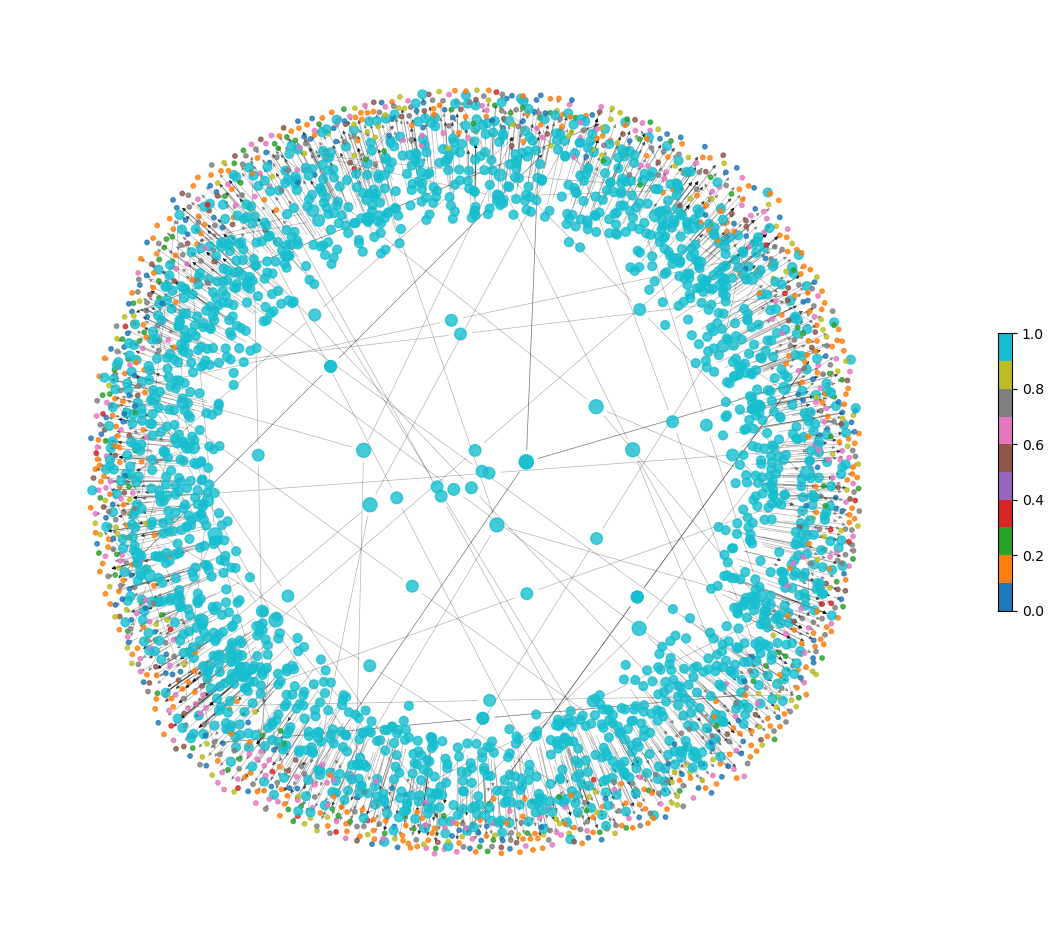

In [351]:
plt.figure(figsize=(15,12))
cmap=plt.cm.tab10
 
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.3, width=0.5, arrowsize=5)
nc = nx.draw_networkx_nodes(graph, pos, alpha=0.8, node_color=colors, cmap=cmap, node_size=[s*30+10 for s in deg.values()])
labels = nx.get_node_attributes(graph, 'IPC') 
pos_nodes = nudge(pos, 0, 0.04) 

#lc = nx.draw_networkx_labels(graph, pos_nodes, labels=labels, font_size=10, alpha=0.8)
#nc.set_edgecolor('black')

norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm,shrink=0.3)

plt.axis('off')
plt.show()

In [406]:
edge_list = np.array(DOI[['Citing_appln_id','Cited_Appln_id']]).astype(int)

graph = nx.DiGraph()
graph.add_edges_from(edge_list)

for i in tqdm(range(len(DOI))):
    graph.add_node(np.array(DOI)[i][0], date=np.array(DOI)[i][1])
    graph.add_node(np.array(DOI)[i][2], date=np.array(DOI)[i][3])

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 22121.91it/s]


In [407]:
groups = set(nx.get_node_attributes(graph,'date').values())
mapping = dict(zip(sorted(groups),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['date']] for n in nodes]

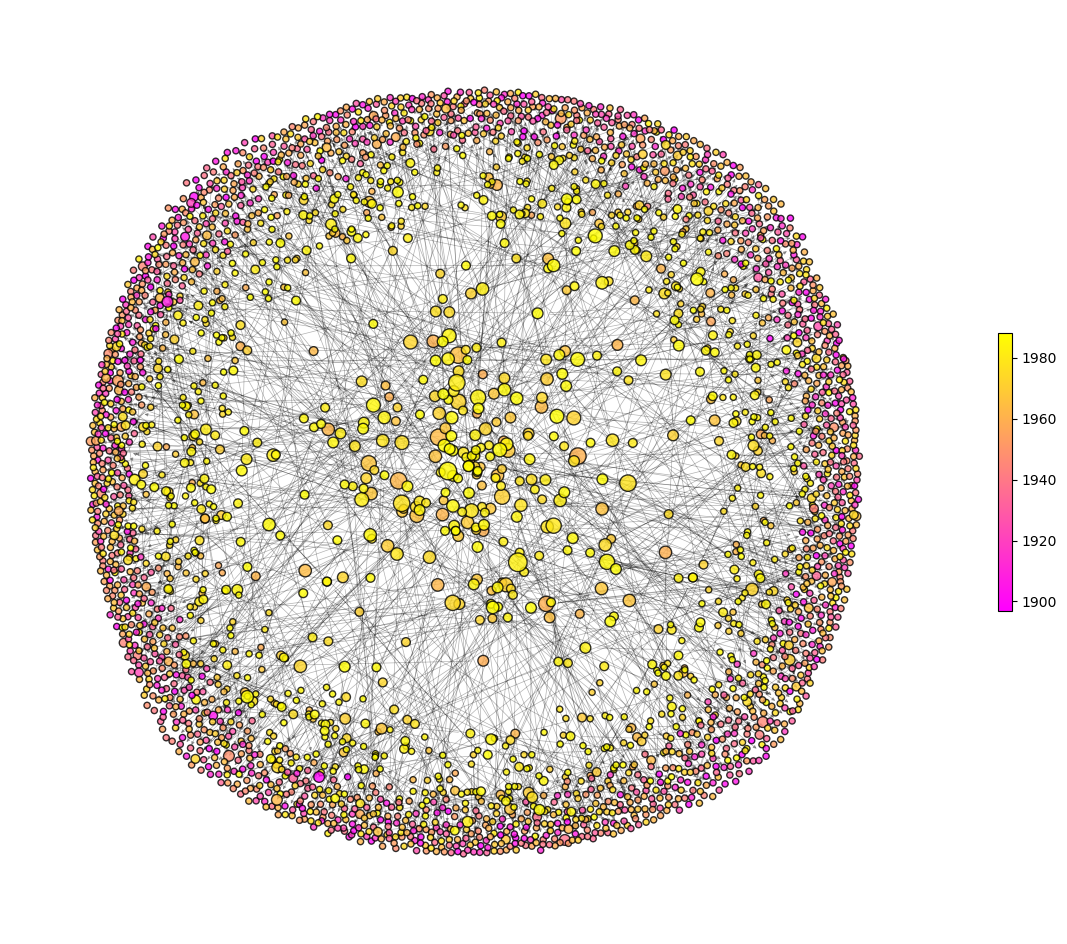

In [408]:
plt.figure(figsize=(15,12))
cmap=plt.cm.spring
deg = dict(graph.degree)

pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.3, width=0.5, arrowsize=5)
nc = nx.draw_networkx_nodes(graph, pos, alpha=0.8, node_color=colors, cmap=cmap, node_size=[s*20 for s in deg.values()])
nc.set_edgecolor('black')

norm = mpl.colors.Normalize(vmin=min_date,vmax=max_date)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm,shrink=0.3)

plt.axis('off')
plt.show()

In [ ]:
quantity = 500

#full = len(GB_patent_ids_n)

store_cit_share = np.zeros(quantity)
for i in tqdm(range(quantity)):
    countries_cited = list((GB_citations.loc[GB_citations['Citing_pub_nbr'] == GB_patent_ids_n[i]])['Cited_App_auth'])
    GB_count = countries_cited.count(COUNTRY_CODE)/len(countries_cited)
    store_cit_share[i] = GB_count
    
share_table = pd.DataFrame(np.stack((GB_patent_ids_n[:quantity], store_cit_share), axis=1),columns=['pct_nbr','Share'])

In [ ]:
Assigned_shapefile = GB_patents.merge(share_table, left_on='pct_nbr', right_on='pct_nbr')
Assigned_shapefile = space_GB_NUTS.merge(Assigned_shapefile, left_on='NUTS_ID', right_on='reg_code')

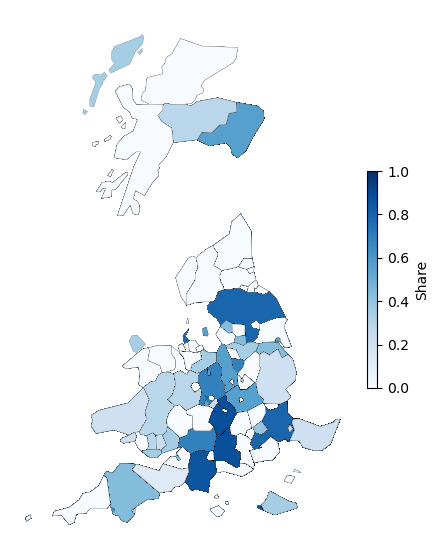

In [269]:
# Plotting
cmap = 'Blues'
Assigned_shapefile.plot(figsize=(7,7), column='Share', cmap=cmap, linewidth=0.1, edgecolor='black')
norm = plt.Normalize(Assigned_shapefile['Share'].min(), Assigned_shapefile['Share'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, fraction=0.02, pad=0.02)

cbar.set_label('Share')

plt.axis("off")
plt.show()

In [409]:
# Modifiable parameters
NUTS_level = 3
IPC_level = 1

# Loading shapefile and restricting to UK and selected NUTS
space_GB = space.loc[space['CNTR_CODE'] == "UK"]
space_GB_NUTS3 = space_GB.loc[space['LEVL_CODE'] == NUTS_level]

# Restricting citations data to UK
citations_data_GB = citations_data.loc[citations_data['ctry_code'] == "GB"]

# Merging citations and shapefile
merged_data = space_GB_NUTS3.merge(citations_data_GB, left_on='FID', right_on='reg_code')

IPC_reduced = IPC_translations.loc[IPC_translations['IPC'].str.len()==IPC_level]
merged_data["IPC"] = merged_data["IPC"].str[0:IPC_level]
merged_data_named = merged_data.merge(IPC_reduced, left_on='IPC', right_on='IPC')

contents = np.sort(list(merged_data_named["IPC"].unique())) # All possible IPC
dates = np.sort(list(merged_data_named["prio_year"].unique())) # All possible IPC

NameError: name 'space' is not defined

In [116]:
select = 5
merged_data_named_year = merged_data_named.loc[merged_data_named['prio_year'] == dates[select]] # Full data
edge_list = np.array(merged_data_named_year[['Citing_appln_id', 'Cited_Appln_id']]) # Creating edge list
merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique()

array([1980])

In [117]:
graph = nx.DiGraph()
graph.add_edges_from(edge_list)

for i in range(len(np.array(graph.nodes()))):
    graph.add_node(np.array(graph.nodes())[i], date=merged_data_named.loc[merged_data_named['Citing_appln_id'] == int(np.array(graph.nodes())[7])]['prio_year'].unique())

In [160]:
plt.figure(figsize=(10,8))

groups = set(nx.get_node_attributes(graph,'date').values())
mapping = dict(zip(sorted(groups),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['date']] for n in nodes]

pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.2, width=0.5, arrowsize=5)
nc = nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=40, cmap=plt.cm.Blues)

nc.set_edgecolor('black')
plt.colorbar(nc,shrink=0.5)
plt.axis('off')
plt.show()

KeyError: 'date'

<Figure size 1000x800 with 0 Axes>

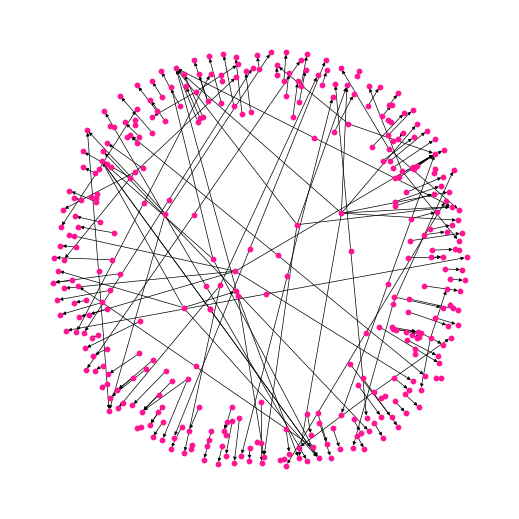

In [57]:
plt.figure(figsize=(5,5))
nx.draw(graph,  
        with_labels = False,
        node_color='deeppink',
        node_size=10,
        width=0.5,
        arrowsize=5,
        font_color="black",
        font_size=2)